In [165]:
import pandas as pd
import datetime
import numpy as np
import os
import glob
import config

In [166]:
feather_paths = config.get_feather_paths(config.processed_data_path)
feather_path = feather_paths[3]
print(feather_path)

../data/processed/2018_11.feather


In [167]:
df = pd.read_feather(feather_path)

In [168]:
def get_unixtime(timestamp):
    return timestamp.timestamp()

df['unix_time'] = df['timestamp'].apply(get_unixtime)

In [170]:
def broadband_func(x): 
    return 10**(x/10)

def calc_spl(df):
    # Apply function, map to dataframe, sum by row, take the log and then normalise to maximum value of zero.
    df['broadband_spl'] = 10*np.log10(df.loc[:, '25.1188643150958':'25118.8643150958'].applymap(broadband_func).sum(axis=1))
    df['broadband_spl'] = df['broadband_spl'] - df['broadband_spl'].max()
    
    # Calculate 'background' sound level using moving average.
    window = 60*60*2 
    df['background' ] = df['broadband_spl'].rolling(window).mean()    
    
    df = df.dropna(axis='rows', subset=['background']).reset_index(drop=True)
    
    return df

df = calc_spl(df)

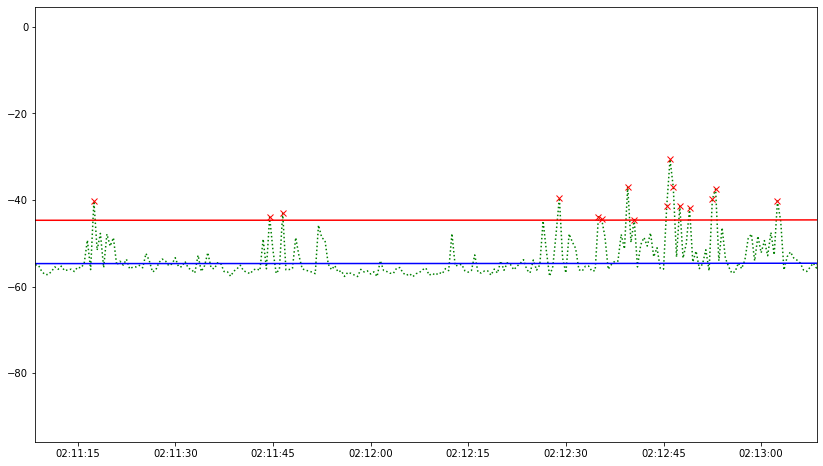

In [199]:
plt.figure(figsize=(14,8))
plt.plot(df['timestamp'], df['broadband_spl'], 'g:')
plt.plot(df['timestamp'], df['background'], '-', color='b')
plt.plot(df['timestamp'], df['background']+10, '-', color='r')
transient_mask = df['broadband_spl'] > (df['background']+10)
plt.plot(df['timestamp'][transient_mask], df['broadband_spl'][transient_mask], 'rx')
plt.xlim(df['timestamp'].min()+ datetime.timedelta(hours=1, minutes=8), df['timestamp'].min() + datetime.timedelta(hours=1,minutes=10))

'''
for i in range(1, int(df['unix_time'].max()-df['unix_time'].min())//60**2):
    plt.axvline(df['timestamp'].min() + datetime.timedelta(seconds=i*60**2), ls='--')
'''
    
plt.show()

In [179]:
df.to_feather(config.interim_data_path + '/2018_11.feather')